## Notebook to analyze latent factors if present for features, both GEX and ATAC, that are associated with age using multiple dimensionality results and done per cell-type, both broad and cluster specific

- PCA
- NMF
- ICA
- VAE

In [1]:
!date

Thu May 16 17:19:15 EDT 2024


#### import libraries

In [2]:
from sklearn.decomposition import PCA, NMF, FastICA
from pandas import DataFrame as PandasDF, read_csv, concat, read_parquet, Series
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc_context
from numpy import cumsum, arange, argsort, abs as np_abs
from sklearn.metrics import r2_score, mean_squared_error
from kneed import KneeLocator

#### set notebook variables

In [3]:
# parameters
category = 'curated_type' # 'curated_type' for broad and 'cluster_name' for specific

In [4]:
# parameters
project = 'aging_phase2'
if category == 'curated_type':
    prefix_type = 'broad'
elif category == 'cluster_name':
    prefix_type = 'specific' 

# directories
wrk_dir = '/labshare/raph/datasets/adrd_neuro/brain_aging/phase2'
quants_dir = f'{wrk_dir}/quants'
results_dir = f'{wrk_dir}/results'
figures_dir = f'{wrk_dir}/figures'

# in files

# out files

# constants
DEBUG = True
modalities = ['GEX', 'ATAC']

#### functions

In [5]:
def important_loadings(components, feature_names, feature_types):
    for index, component_loadings in enumerate(components):
        print(f'#### component {index} ####')
        loadings_abs = np_abs(component_loadings)
        sorted_abs_indices = argsort(loadings_abs)
        sorted_abs_loadings = loadings_abs[sorted_abs_indices]
        print(sorted_abs_loadings.shape)
        # find the knee for loadings
        knee = KneeLocator(arange(1, len(sorted_abs_loadings)+1), cumsum(sorted_abs_loadings), 
                           S=1.0, curve='convex', direction='increasing')
        knee.plot_knee()
        plt.show()
        knee.plot_knee_normalized()
        plt.show()    
        print(f'knee at component {knee.knee}')
        feature_count = int(knee.knee)
        features_sers = Series(data=component_loadings, index=feature_names)
        selected_features = features_sers.loc[features_sers.sort_values(key=abs, ascending=False).head(feature_count).index]
        print(selected_features.shape)
        display(selected_features.sort_values(key=abs, ascending=False).head())
        print(f'best number of features is {feature_count} with minimum absolute loading of {selected_features.abs().min()}')
        gex_count = len(set(selected_components.index) & set(feature_types.get('GEX')))/len(feature_types.get('GEX'))*100
        atac_count = len(set(selected_components.index) & set(feature_types.get('ATAC')))/len(feature_types.get('ATAC'))*100
        print(f'includes {gex_count:.1f} genes and {atac_count:.1f} peaks') 

def iterate_model_component_counts(max_count: int, data_df: PandasDF, 
                                   model_type: str=['PCA', 'NMF', 'ICA']) -> (list, list):
    r2_rets = []
    rmse_rets = []
    for comp_num in arange(1, max_count+1):    
        _,r2,rmse = generate_selected_model(comp_num, data_df, model_type)
        r2_rets.append(r2)
        rmse_rets.append(rmse)
    return r2_rets, rmse_rets

def generate_selected_model(n_comps: int, data_df: PandasDF, 
                            model_type: str=['PCA', 'NMF', 'ICA']) -> (PandasDF, float, float):
    if model_type == 'PCA':
        model = PCA(n_components=n_comps, random_state=42)
    if model_type == 'NMF':
        model = NMF(n_components=n_comps, init='random', random_state=42, max_iter=500)
    if model_type == 'ICA':
        model = FastICA(n_components=n_comps, random_state=42)        
    components= model.fit_transform(data_df)
    recon_input = model.inverse_transform(components)
    r2 = r2_score(y_true=data_df, y_pred=recon_input)
    rmse = mean_squared_error(data_df, recon_input, squared=False)
    print(f'{model_type} with {n_comps} components accuracy is {r2:.4f}, RMSE is {rmse:.4f}')  
    
    ret_df = PandasDF(data=components, index=data_df.index).round(4)
    ret_df = ret_df.add_prefix(f'{model_type}_')
    return ret_df, r2, rmse

def component_from_max_curve(scores, label: str=['R2', 'RMSE']) -> int:
    if label == 'R2':
        data_curve = 'concave'
        data_direction = 'increasing'
    if label == 'RMSE':
        data_curve = 'convex'
        data_direction = 'decreasing'        
    knee = KneeLocator(arange(1, len(scores)+1), scores, 
                       S=1.0, curve=data_curve, direction=data_direction)
    print(f'best curve at knee {knee.knee}')
    num_comp = int(knee.knee)
    exp_value = scores[num_comp-1]
    print(f'best number of components is {num_comp} at {label} of {exp_value}')
    knee.plot_knee()
    plt.show()
    knee.plot_knee_normalized()
    plt.show()
    return num_comp

#### load age associated feature results
get the age associated GEX and ATA features need per cell-type

In [6]:
%%time
age_results = []
for modality in modalities:
    print(modality)
    in_file = f'{results_dir}/{project}.{modality}.{prefix_type}.glm_tweedie_fdr_filtered.age.csv'
    this_df = read_csv(in_file)
    this_df['modality'] = modality
    age_results.append(this_df)
age_results_df = concat(age_results)
print(f'shape of the age results is {age_results_df.shape}')
if DEBUG:
    display(age_results_df.sample(5))
    display(age_results_df.modality.value_counts())
    display(age_results_df.tissue.value_counts())

GEX
ATAC
shape of the age results is (36752, 10)


,feature,intercept,coef,stderr,z,p-value,tissue,type,fdr_bh,modality
22397,chr4:101835033-101835838,-3.514719,0.023321,0.005098,4.574546,4.772547e-06,Micro,curated_type,0.001770,ATAC
32462,chr11:116073606-116074525,-9.872426,0.031486,0.008286,3.799982,1.447065e-04,Astro,curated_type,0.014859,ATAC
12959,chr16:57061064-57061938,-5.925314,0.023062,0.005401,4.270196,1.953013e-05,Micro,curated_type,0.004391,ATAC
22204,chr8:27546454-27547122,0.699115,0.023124,0.004453,5.193416,2.064696e-07,Micro,curated_type,0.000203,ATAC
503,LINC02055,9.070817,0.027739,0.008105,3.422506,6.204674e-04,ExN,curated_type,0.036900,GEX


ATAC    34257
GEX      2495
Name: modality, dtype: int64

Micro       14278
Astro       10507
OPC          6807
ExN          2109
OD           1916
InN           650
PeriVasc      433
VLMC           52
Name: tissue, dtype: int64

CPU times: user 96.6 ms, sys: 25.8 ms, total: 122 ms
Wall time: 122 ms


### load the feature quantifications

In [7]:
%%time
cell_type = 'ExN'
cell_type_quants = []
modality_features = {}
for modality in modalities:
    features_to_keep = age_results_df.loc[(age_results_df.tissue == cell_type) & 
                                          (age_results_df.modality == modality)].feature.to_list()
    print(modality, len(features_to_keep))
    modality_features[modality] = features_to_keep
    in_file = f'{quants_dir}/{project}.{modality}.{prefix_type}.{cell_type}.pb.parquet'
    df = read_parquet(in_file)
    df = df[features_to_keep]    
    # df = df[features_to_keep + ['cell_count']]
    # df = df.rename(columns={'cell_count': f'{modality}_cell_count'})
    print(modality, df.shape)
    cell_type_quants.append(df)
quants_df = concat(cell_type_quants, axis='columns', join='inner')
print(f'shape of feature quantifications for {cell_type} is {quants_df.shape}')
if DEBUG:
    display(quants_df.sample(5))

GEX 610
GEX (36, 610)
ATAC 1499
ATAC (36, 1499)
shape of feature quantifications for ExN is (36, 2109)


,DCLK3,COL1A2,AL138828.1,MYCNOS,SFT2D3,AL138689.2,AL135791.1,AP000462.2,NGF-AS1,REXO2,...,chr15:74382103-74383014,chr4:37896254-37897017,chr10:28721910-28722814,chrX:41516589-41517397,chr4:25925586-25926432,chr12:100778901-100779899,chr10:103659733-103660585,chr12:103697690-103698456,chr22:44571646-44572526,chrX:118254353-118255289
sample_id,,,,,,,,,,,,,,,,,,,,,
Aging130,0.707220,0.087041,0.331229,0.479697,0.426707,0.967323,0.841334,0.443564,0.471119,0.635027,...,0.540583,0.109733,0.404213,0.361813,0.289198,0.056898,0.419878,0.382470,0.340015,0.450028
Aging122,0.357498,0.154830,0.338332,0.514961,0.666251,0.063567,0.264812,0.017654,0.322422,0.242145,...,0.606640,0.916681,0.668765,0.492890,1.000000,0.904798,0.947933,1.000000,0.554636,0.949390
Aging123,0.698828,0.107115,1.000000,0.756356,0.774877,0.269665,0.411813,0.127272,0.242519,0.326164,...,0.446376,0.277842,0.503194,0.137849,0.371394,0.480911,0.436230,0.371228,0.351497,0.665849
Aging141,0.247941,0.125236,0.721706,0.366574,0.507915,0.621369,0.572773,0.290403,0.099714,0.372647,...,0.564342,0.447013,0.332554,0.402159,0.408297,0.026762,0.414274,0.108780,0.324162,0.734333
Aging077,0.222169,0.141571,0.234548,0.310533,0.288579,0.246334,0.405959,0.131142,0.225636,0.456391,...,0.757682,0.508507,0.453806,0.421685,0.585732,0.305183,0.507989,0.482801,0.753356,0.715847


CPU times: user 34.5 s, sys: 15.4 s, total: 50 s
Wall time: 25 s


### using PCA

#### find number of components to use

In [8]:
%%time
max_count = int(min(quants_df.shape[0], quants_df.shape[1])/2)
print(f'max count is {max_count}')

r2_values, rmse_values = iterate_model_component_counts(max_count, quants_df, 'PCA')

max count is 18
PCA with 1 components accuracy is 0.4064, RMSE is 0.1755
PCA with 2 components accuracy is 0.5289, RMSE is 0.1559
PCA with 3 components accuracy is 0.5976, RMSE is 0.1441
PCA with 4 components accuracy is 0.6528, RMSE is 0.1335
PCA with 5 components accuracy is 0.6943, RMSE is 0.1254
PCA with 6 components accuracy is 0.7207, RMSE is 0.1197
PCA with 7 components accuracy is 0.7443, RMSE is 0.1145
PCA with 8 components accuracy is 0.7667, RMSE is 0.1093
PCA with 9 components accuracy is 0.7867, RMSE is 0.1045
PCA with 10 components accuracy is 0.8050, RMSE is 0.0998
PCA with 11 components accuracy is 0.8223, RMSE is 0.0951
PCA with 12 components accuracy is 0.8377, RMSE is 0.0909
PCA with 13 components accuracy is 0.8507, RMSE is 0.0870
PCA with 14 components accuracy is 0.8627, RMSE is 0.0834
PCA with 15 components accuracy is 0.8741, RMSE is 0.0798
PCA with 16 components accuracy is 0.8845, RMSE is 0.0764
PCA with 17 components accuracy is 0.8882, RMSE is 0.0730
PCA wit

best curve at knee 5
best number of components is 5 at RMSE of 0.1253693550825119


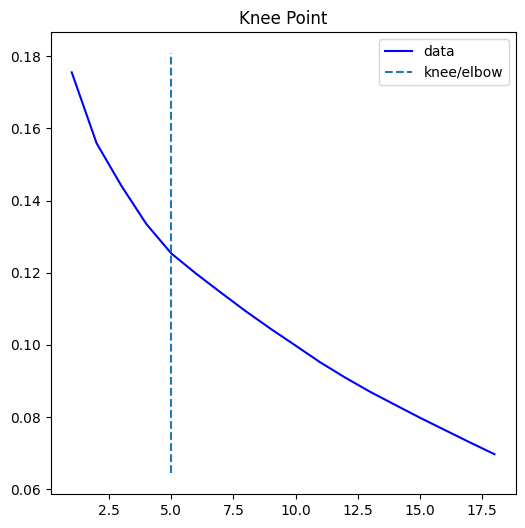

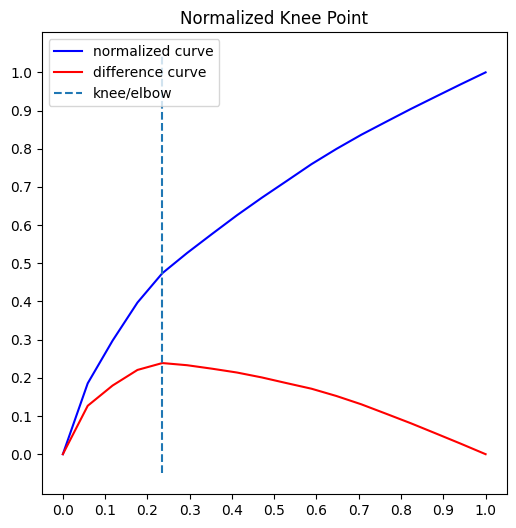

best curve at knee 5
best number of components is 5 at R2 of 0.6942782230446927


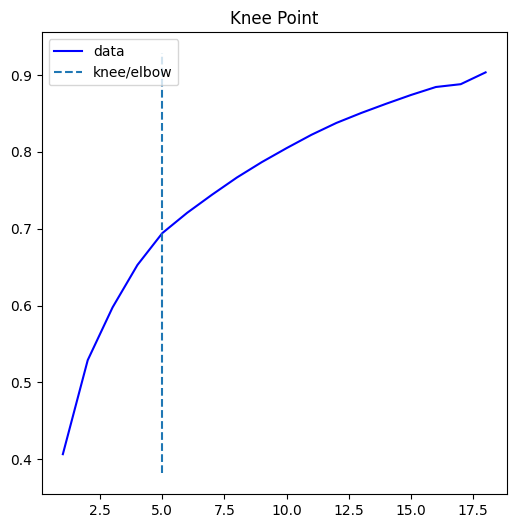

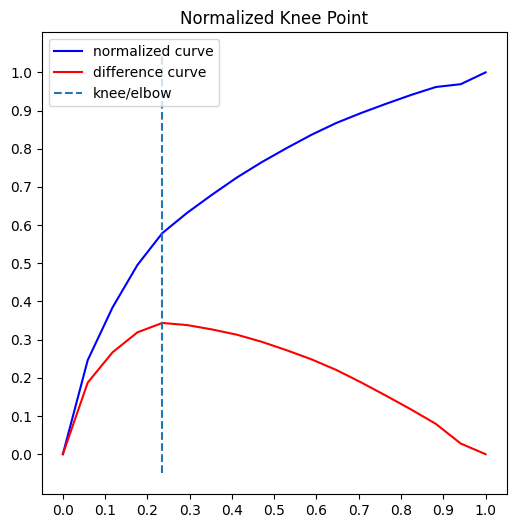

5


In [9]:
knee_rmse = component_from_max_curve(rmse_values, 'RMSE')
knee_r2 = component_from_max_curve(r2_values, 'R2')
num_comp = max(knee_rmse, knee_r2)
print(num_comp)

#### regenerate the PCA model at the selected component size

In [10]:
pca_df,_,_ = generate_selected_model(num_comp, quants_df, 'PCA')
if DEBUG:
    print(pca_df.shape)
    display(pca_df.head())

PCA with 5 components accuracy is 0.6943, RMSE is 0.1254
(36, 5)


,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4
sample_id,,,,,
Aging070,13.7716,-4.9333,0.3465,0.4841,0.6107
Aging077,8.2643,0.6764,1.7261,2.3144,0.9980
Aging081,-12.0938,3.6721,4.9551,-5.3402,8.2581
Aging085,-5.1865,2.0721,3.1760,0.9659,-1.0745
Aging089,-3.6560,-3.5826,-0.0896,0.2047,-1.0247


#### what are the 'important features' based on their loadings

In [11]:
important_loadings(pca.components_, pca.feature_names_in_, modality_features)

NameError: name 'pca' is not defined

### using NMF

#### find number of components to use

In [ ]:
r2_values, rmse_values = iterate_model_component_counts(max_count, quants_df, 'NMF')

In [ ]:
knee_rmse = component_from_max_curve(rmse_values, 'RMSE')
knee_r2 = component_from_max_curve(r2_values, 'R2')
num_comp = max(knee_rmse, knee_r2)
print(num_comp)

#### regenerate the NMF model at the selected component size

In [ ]:
nmf_df,_,_ = generate_selected_model(num_comp, quants_df, 'NMF')
if DEBUG:
    print(nmf_df.shape)
    display(nmf_df.head())

#### what are the 'important features' based on their loadings

In [ ]:
important_loadings(model.components_, model.feature_names_in_, modality_features)

### using ICA

#### find number of components to use

In [ ]:
r2_values, rmse_values = iterate_model_component_counts(max_count, quants_df, 'ICA')

In [ ]:
knee_rmse = component_from_max_curve(rmse_values, 'RMSE')
knee_r2 = component_from_max_curve(r2_values, 'R2')
num_comp = max(knee_rmse, knee_r2)
print(num_comp)

#### regenerate ICA model at the selected component size

In [ ]:
ica_df,_,_ = generate_selected_model(num_comp, quants_df, 'ICA')
if DEBUG:
    print(ica_df.shape)
    display(ica_df.head())

#### what are the 'important features' based on their loadings

In [ ]:
important_loadings(model.components_, model.feature_names_in_, modality_features)

### using a VAE

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device = 'cpu'
print(device)

In [ ]:
# from pythae.models import VAE, VAEConfig
# from pythae.trainers import BaseTrainerConfig
# from pythae.pipelines.training import TrainingPipeline
# from pythae.models.nn.benchmarks.mnist import Encoder_ResNet_VAE_MNIST, Decoder_ResNet_AE_MNIST

In [ ]:
# import torchvision.datasets as datasets
# mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

# train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.
# eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

In [ ]:
# config = BaseTrainerConfig(
#     output_dir='my_model',
#     learning_rate=1e-4,
#     per_device_train_batch_size=64,
#     per_device_eval_batch_size=64,
#     num_epochs=10, # Change this to train the model a bit more
#     optimizer_cls="AdamW",
#     optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.99)}
# )


# model_config = VAEConfig(
#     input_dim=(1, 28, 28),
#     latent_dim=16
# )

# model = VAE(
#     model_config=model_config,
#     encoder=Encoder_ResNet_VAE_MNIST(model_config), 
#     decoder=Decoder_ResNet_AE_MNIST(model_config)     
# )

In [ ]:
# pipeline = TrainingPipeline(
#     training_config=config,
#     model=model
# )

In [ ]:
# pipeline(
#     train_data=train_dataset,
#     eval_data=eval_dataset
# )

In [ ]:
# import os
# from pythae.models import AutoModel

In [ ]:
# last_training = sorted(os.listdir('my_model'))[-1]
# trained_model = AutoModel.load_from_folder(os.path.join('my_model', last_training, 'final_model'))

In [ ]:
# from pythae.samplers import NormalSampler

In [ ]:
# # create normal sampler
# normal_samper = NormalSampler(
#     model=trained_model
# )

In [ ]:
# # sample
# gen_data = normal_samper.sample(
#     num_samples=25
# )

In [ ]:
# # show results with normal sampler
# fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

# for i in range(5):
#     for j in range(5):
#         axes[i][j].imshow(gen_data[i*5 +j].cpu().squeeze(0), cmap='gray')
#         axes[i][j].axis('off')
# plt.tight_layout(pad=0.)

In [ ]:
# from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig

In [ ]:
# # set up GMM sampler config
# gmm_sampler_config = GaussianMixtureSamplerConfig(
#     n_components=10
# )

# # create gmm sampler
# gmm_sampler = GaussianMixtureSampler(
#     sampler_config=gmm_sampler_config,
#     model=trained_model
# )

# # fit the sampler
# gmm_sampler.fit(train_dataset)

In [ ]:
# # sample
# gen_data = gmm_sampler.sample(
#     num_samples=25
# )

In [ ]:
# # show results with gmm sampler
# fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

# for i in range(5):
#     for j in range(5):
#         axes[i][j].imshow(gen_data[i*5 +j].cpu().squeeze(0), cmap='gray')
#         axes[i][j].axis('off')
# plt.tight_layout(pad=0.)

In [ ]:
# reconstructions = trained_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

In [ ]:
# # show reconstructions
# fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

# for i in range(5):
#     for j in range(5):
#         axes[i][j].imshow(reconstructions[i*5 + j].cpu().squeeze(0), cmap='gray')
#         axes[i][j].axis('off')
# plt.tight_layout(pad=0.)

In [ ]:
# # show the true data
# fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

# for i in range(5):
#     for j in range(5):
#         axes[i][j].imshow(eval_dataset[i*5 +j].cpu().squeeze(0), cmap='gray')
#         axes[i][j].axis('off')
# plt.tight_layout(pad=0.)

In [ ]:
# interpolations = trained_model.interpolate(eval_dataset[:5].to(device), eval_dataset[5:10].to(device), granularity=10).detach().cpu()

In [ ]:
# # show interpolations
# fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

# for i in range(5):
#     for j in range(10):
#         axes[i][j].imshow(interpolations[i, j].cpu().squeeze(0), cmap='gray')
#         axes[i][j].axis('off')
# plt.tight_layout(pad=0.)